In [1]:
!git clone https://github.com/Anonymous-GT11/SAFRAN_ENSAI_2025
# Verify that we have sucessfully clone the repo and go the place where the repo is stored
%cd /content/SAFRAN_ENSAI_2025
!ls


Cloning into 'SAFRAN_ENSAI_2025'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 115 (delta 36), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (115/115), 2.46 MiB | 8.52 MiB/s, done.
Resolving deltas: 100% (36/36), done.
/content/SAFRAN_ENSAI_2025
data  performancemodel_ENSAI  performancemodel_ENSAI.zip  README.md


In [2]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torch-geometric-temporal

2.8.0+cu126
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 109.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 60.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 4.7 MB/s eta 0:00:00


In [19]:
from torch_geometric_temporal.dataset import MTMDatasetLoader
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

# Load the MTMdataset from Pytorch Geometric Temporal


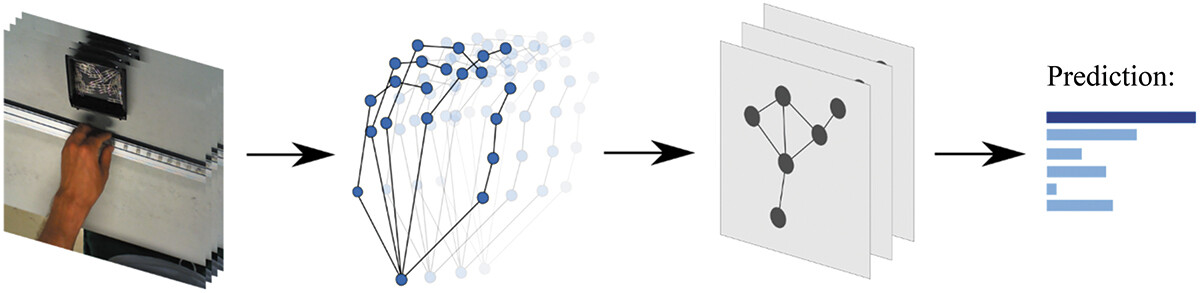

A dataset of Methods-Time Measurement-1 (MTM-1) motions, signalled as consecutive video frames of 21 3D hand keypoints, acquired via MediaPipe Hands from RGB-Video material. Vertices are the finger joints of the human hand and edges are the bones connecting them. The targets are manually labeled for each frame, according to one of the five MTM-1 motions (classes
): Grasp, Release, Move, Reach, Position plus a negative class for frames without graph signals (no hand present). This is a classification task where
 consecutive frames need to be assigned to the corresponding class
. The data x is returned in shape (3, 21, T), the target is returned one-hot-encoded in shape (T, 6).

[lWikipedia of the Methods-time measurement system](https://en.wikipedia.org/wiki/Methods-time_measurement)

In [22]:
# we prepare a function to load the dataset
def load_dataset(n_frames):
  # Load original dataset
  loader = MTMDatasetLoader()
  dataset = loader.get_dataset(frames = n_frames)

  # Extract components of the temporal dataset
  # These are lists (or iterables) over time
  edge_index = dataset.edge_index
  edge_weight = dataset.edge_weight
  features = dataset.features
  targets = dataset.targets

  # Transpose the feature tensors and convert to float
  # Each feature tensor originally has shape (3, 21, n_frames)
  # We want to make it (21, 3, n_frames) that represents 21 nodes, each has a feature  size 3 x n_frames
  new_features = [torch.from_numpy(x).permute(1, 0, 2).float() for x in features]

  # Create a new StaticGraphTemporalSignal with the modified features
  new_dataset = StaticGraphTemporalSignal(
      edge_index=edge_index,
      edge_weight=edge_weight,
      features=new_features,
      targets=targets
  )
  return new_dataset

## First, let's try load frame by frame.


In [24]:
dataset = load_dataset(n_frames=1)

# This dataset contain 14k objects, each is a graph data object
# for example
data = dataset[190]  # Get a graph object

print()
print(data)
print('=============================================================')
print(f'Number of edges: {data.num_edges}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')


Data(x=[21, 3, 1], edge_index=[2, 19], edge_attr=[19], y=[1, 6])
Number of edges: 19
Number of nodes: 21
Average node degree: 0.90


In [25]:
# the target output associated with this one frame is a binary vector size 6
# representing if this frame belongs to which class.
data.y

tensor([[0., 1., 0., 0., 0., 0.]])

You guys can start working with this dataset frame-by-frame. However, as you can guess, it is very difficult to get a right prediction of a hand motion using only one frame. Therefore, we should use multiple frames.

## Second, load multiple frames:

Here, we have a moving windows of size 16 that sweeps through the whole dataset. Therefore, we will also have 14k data point:

In [26]:
dataset = load_dataset(n_frames=16)

# This dataset contain 14k objects, each is a graph data object
# for example
data = dataset[190]  # Get a graph object

print()
print(data)
print('=============================================================')
print(f'Number of edges: {data.num_edges}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')


Data(x=[21, 3, 16], edge_index=[2, 19], edge_attr=[19], y=[16, 6])
Number of edges: 19
Number of nodes: 21
Average node degree: 0.90


This time, the node feature is of size 3 x 16.

Moreover, the target label is 16 vectors, each have size 6. In order to simplfy the problem, you should write a code that taking this [16,6] tensor as input and output a bianry [1,6] tensor, where the element that most presents in the [16,6] will have value 1, while the rest zeros. In other words, you look at the 16 frames in your data point, and assign the class that presents the most as the class of the data point.

In the end, you should have, for each data point data in dataset, data.y is a [1,6] vector.

# Task 1: preparing training and testing dataset
- Using shufffle (see notebook 3) to create dataset, I suggest to you 20% percent test, and 80% train.
- Using mini batches help a lot as your dataset is quite large here



# Task 2: Training an  testing MLP
Here, using only features vectors and not the graph info

# Task 3: Training and testing GNN: